## Prepare Notebook

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc.sampling_jax
import seaborn as sns
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [8, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.9/site-packages/pymc/sampling_jax.py:36: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


## Generate Raw Data

In [20]:
x, y = make_moons(n_samples=130, noise=0.2, random_state=0)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0)

n_train = x_train.shape[0]
n_test = x_test.shape[0]
n = n_train + n_test

idx_train = range(n_train)
idx_test = range(n_train, n_train + n_test)

domain_dim = x.shape[1]

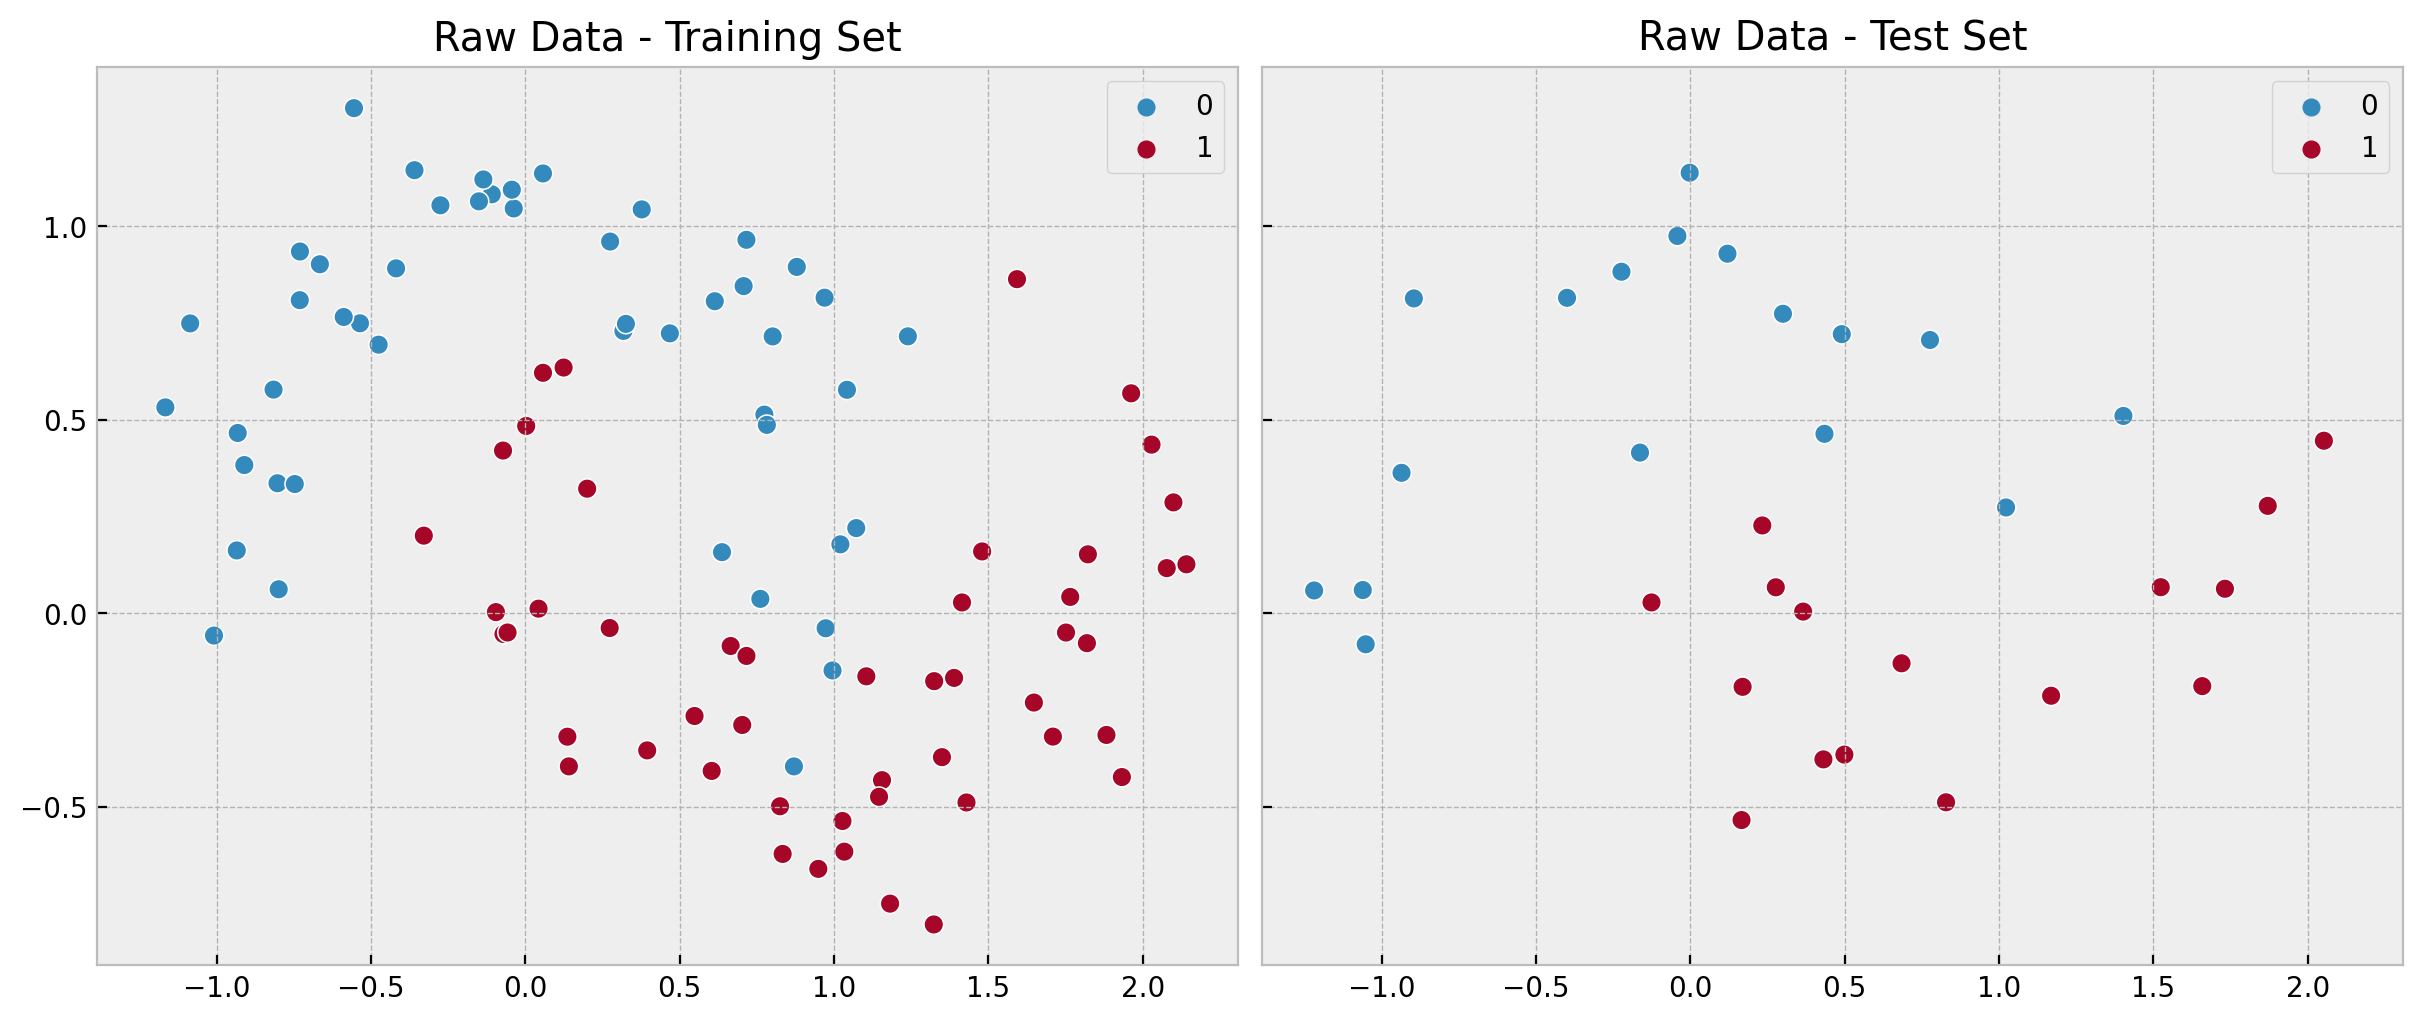

In [6]:
fig, ax = plt.subplots(
    nrows=1, ncols=2, figsize=(12, 5), sharex=True, sharey=True, layout="constrained"
)
sns.scatterplot(x=x_train[:, 0], y=x_train[:, 1], s=50, hue=y_train, ax=ax[0])
ax[0].set(title="Raw Data - Training Set")
sns.scatterplot(x=x_test[:, 0], y=x_test[:, 1], s=50, hue=y_test, ax=ax[1])
ax[1].set(title="Raw Data - Test Set");

## Linear Model

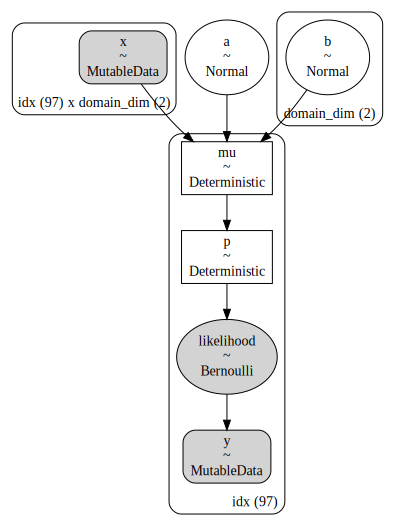

In [7]:
with pm.Model() as linear_model:
    # coordinates
    linear_model.add_coord(name="domain_dim", values=np.arange(domain_dim), mutable=False)
    linear_model.add_coord(name="idx", values=idx_train, mutable=True)
    # data containers
    x_ = pm.MutableData(name="x", value=x_train, dims=("idx", "domain_dim"))
    y_ = pm.MutableData(name="y", value=y_train, dims="idx")
    # priors
    a = pm.Normal(name="a", mu=0, sigma=2)
    b = pm.Normal(name="b", mu=0, sigma=2, dims="domain_dim")
    # model parametrization
    mu = pm.Deterministic(name="mu", var=pm.math.dot(x_, b) + a, dims="idx")
    p = pm.Deterministic(name="p", var=pm.math.invlogit(mu), dims="idx")
    # likelihood
    likelihood = pm.Bernoulli(name="likelihood", p=p, dims="idx", observed=y_)

pm.model_to_graphviz(model=linear_model)

In [8]:
with linear_model:
    linear_idata = pm.sampling_jax.sample_numpyro_nuts(draws=4000, chains=4)
    linear_posterior_predictive = pm.sample_posterior_predictive(trace=linear_idata)

Compiling...
Compilation time =  0:00:02.465002
Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Sampling time =  0:00:03.539277
Transforming variables...
Transformation time =  0:00:00.232616
Computing Log Likelihood...
Log Likelihood time =  0:00:00.669023


In [9]:
az.summary(data=linear_idata, var_names=["a", "b"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.299,0.404,-0.446,1.056,0.004,0.003,9114.0,9958.0,1.0
b[0],1.156,0.364,0.492,1.858,0.004,0.003,10641.0,9941.0,1.0
b[1],-3.307,0.688,-4.623,-2.051,0.007,0.005,9548.0,10149.0,1.0


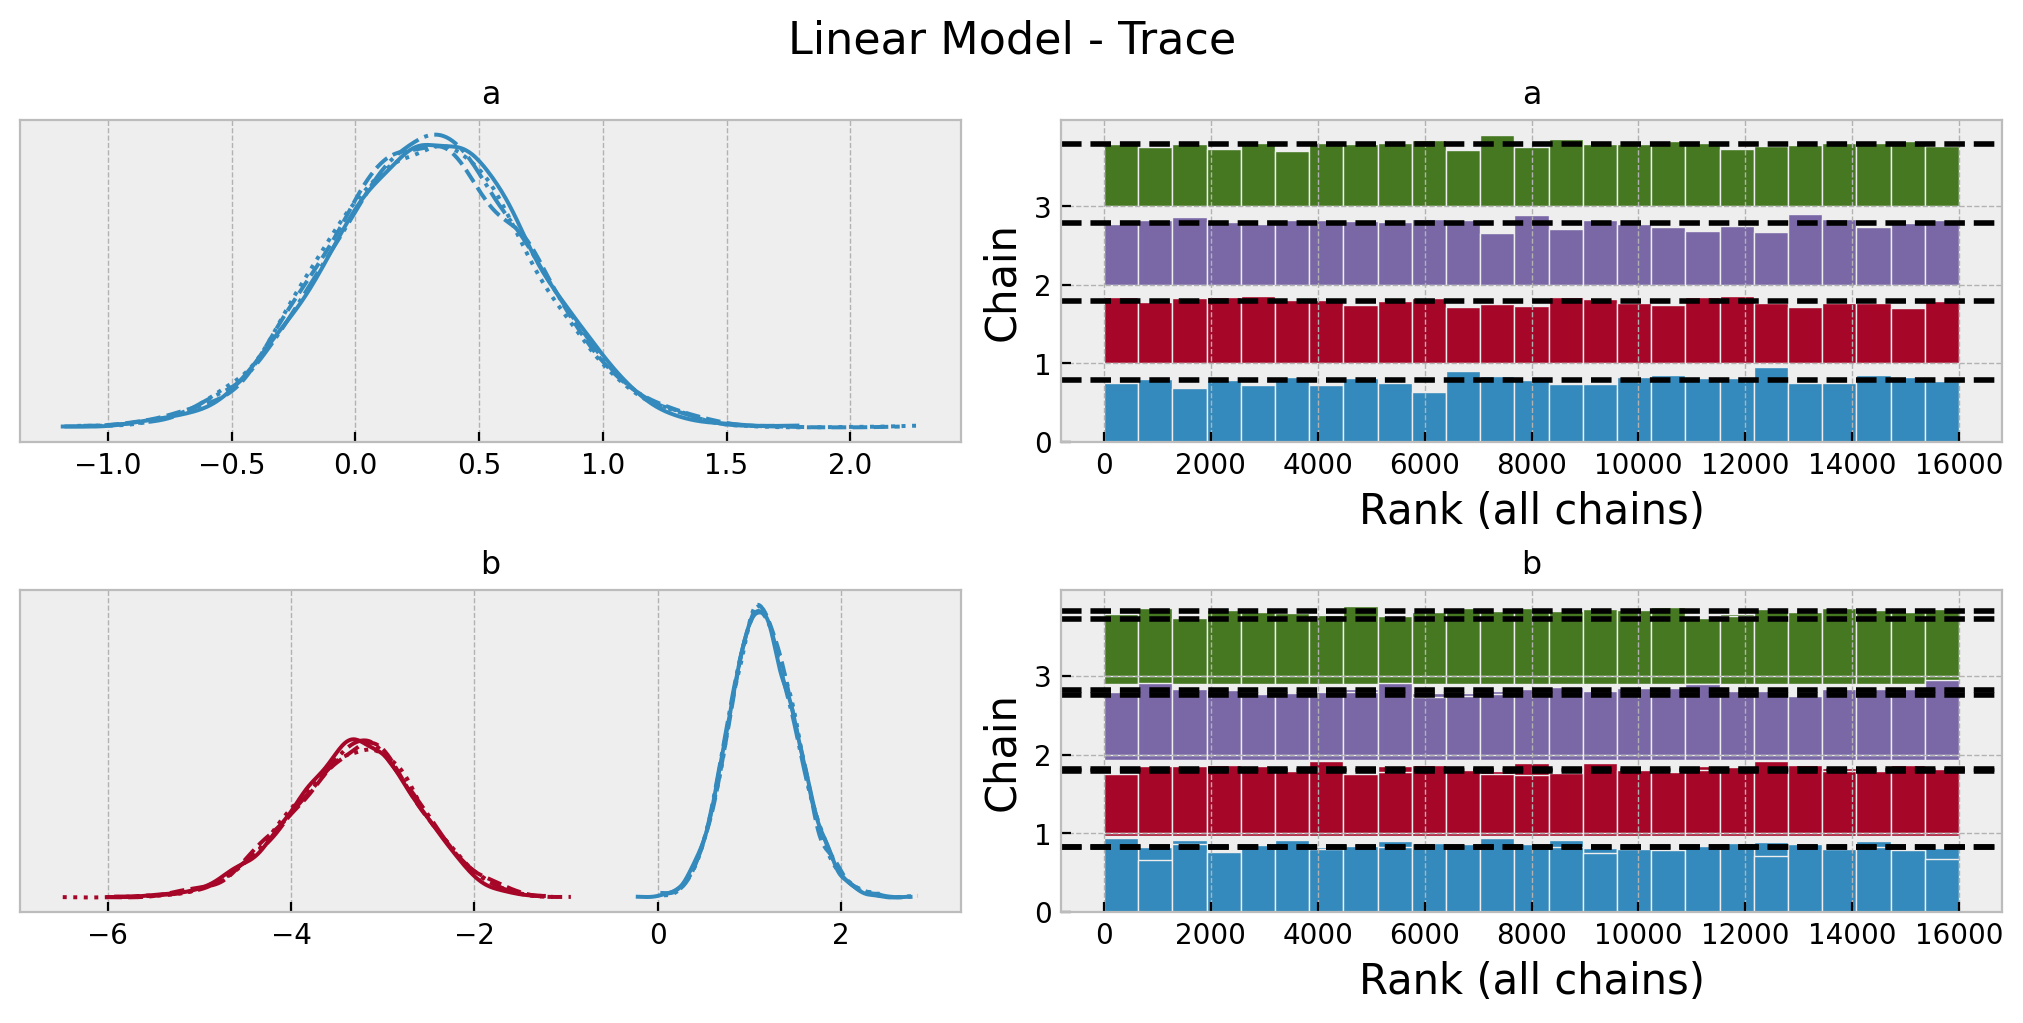

In [10]:
axes = az.plot_trace(
    data=linear_idata,
    var_names=["a", "b"],
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (10, 5), "layout": "constrained"},
)
plt.gcf().suptitle("Linear Model - Trace", fontsize=16);

In [11]:
with linear_model:
    pm.set_data(new_data={"x": x_test, "y": y_test}, coords={"idx": idx_test})
    linear_idata.extend(
        other=pm.sample_posterior_predictive(
            trace=linear_idata,
            var_names=["likelihood", "p"],
            idata_kwargs={"coords": {"idx": idx_test}},
        ),
        join="right",
    )

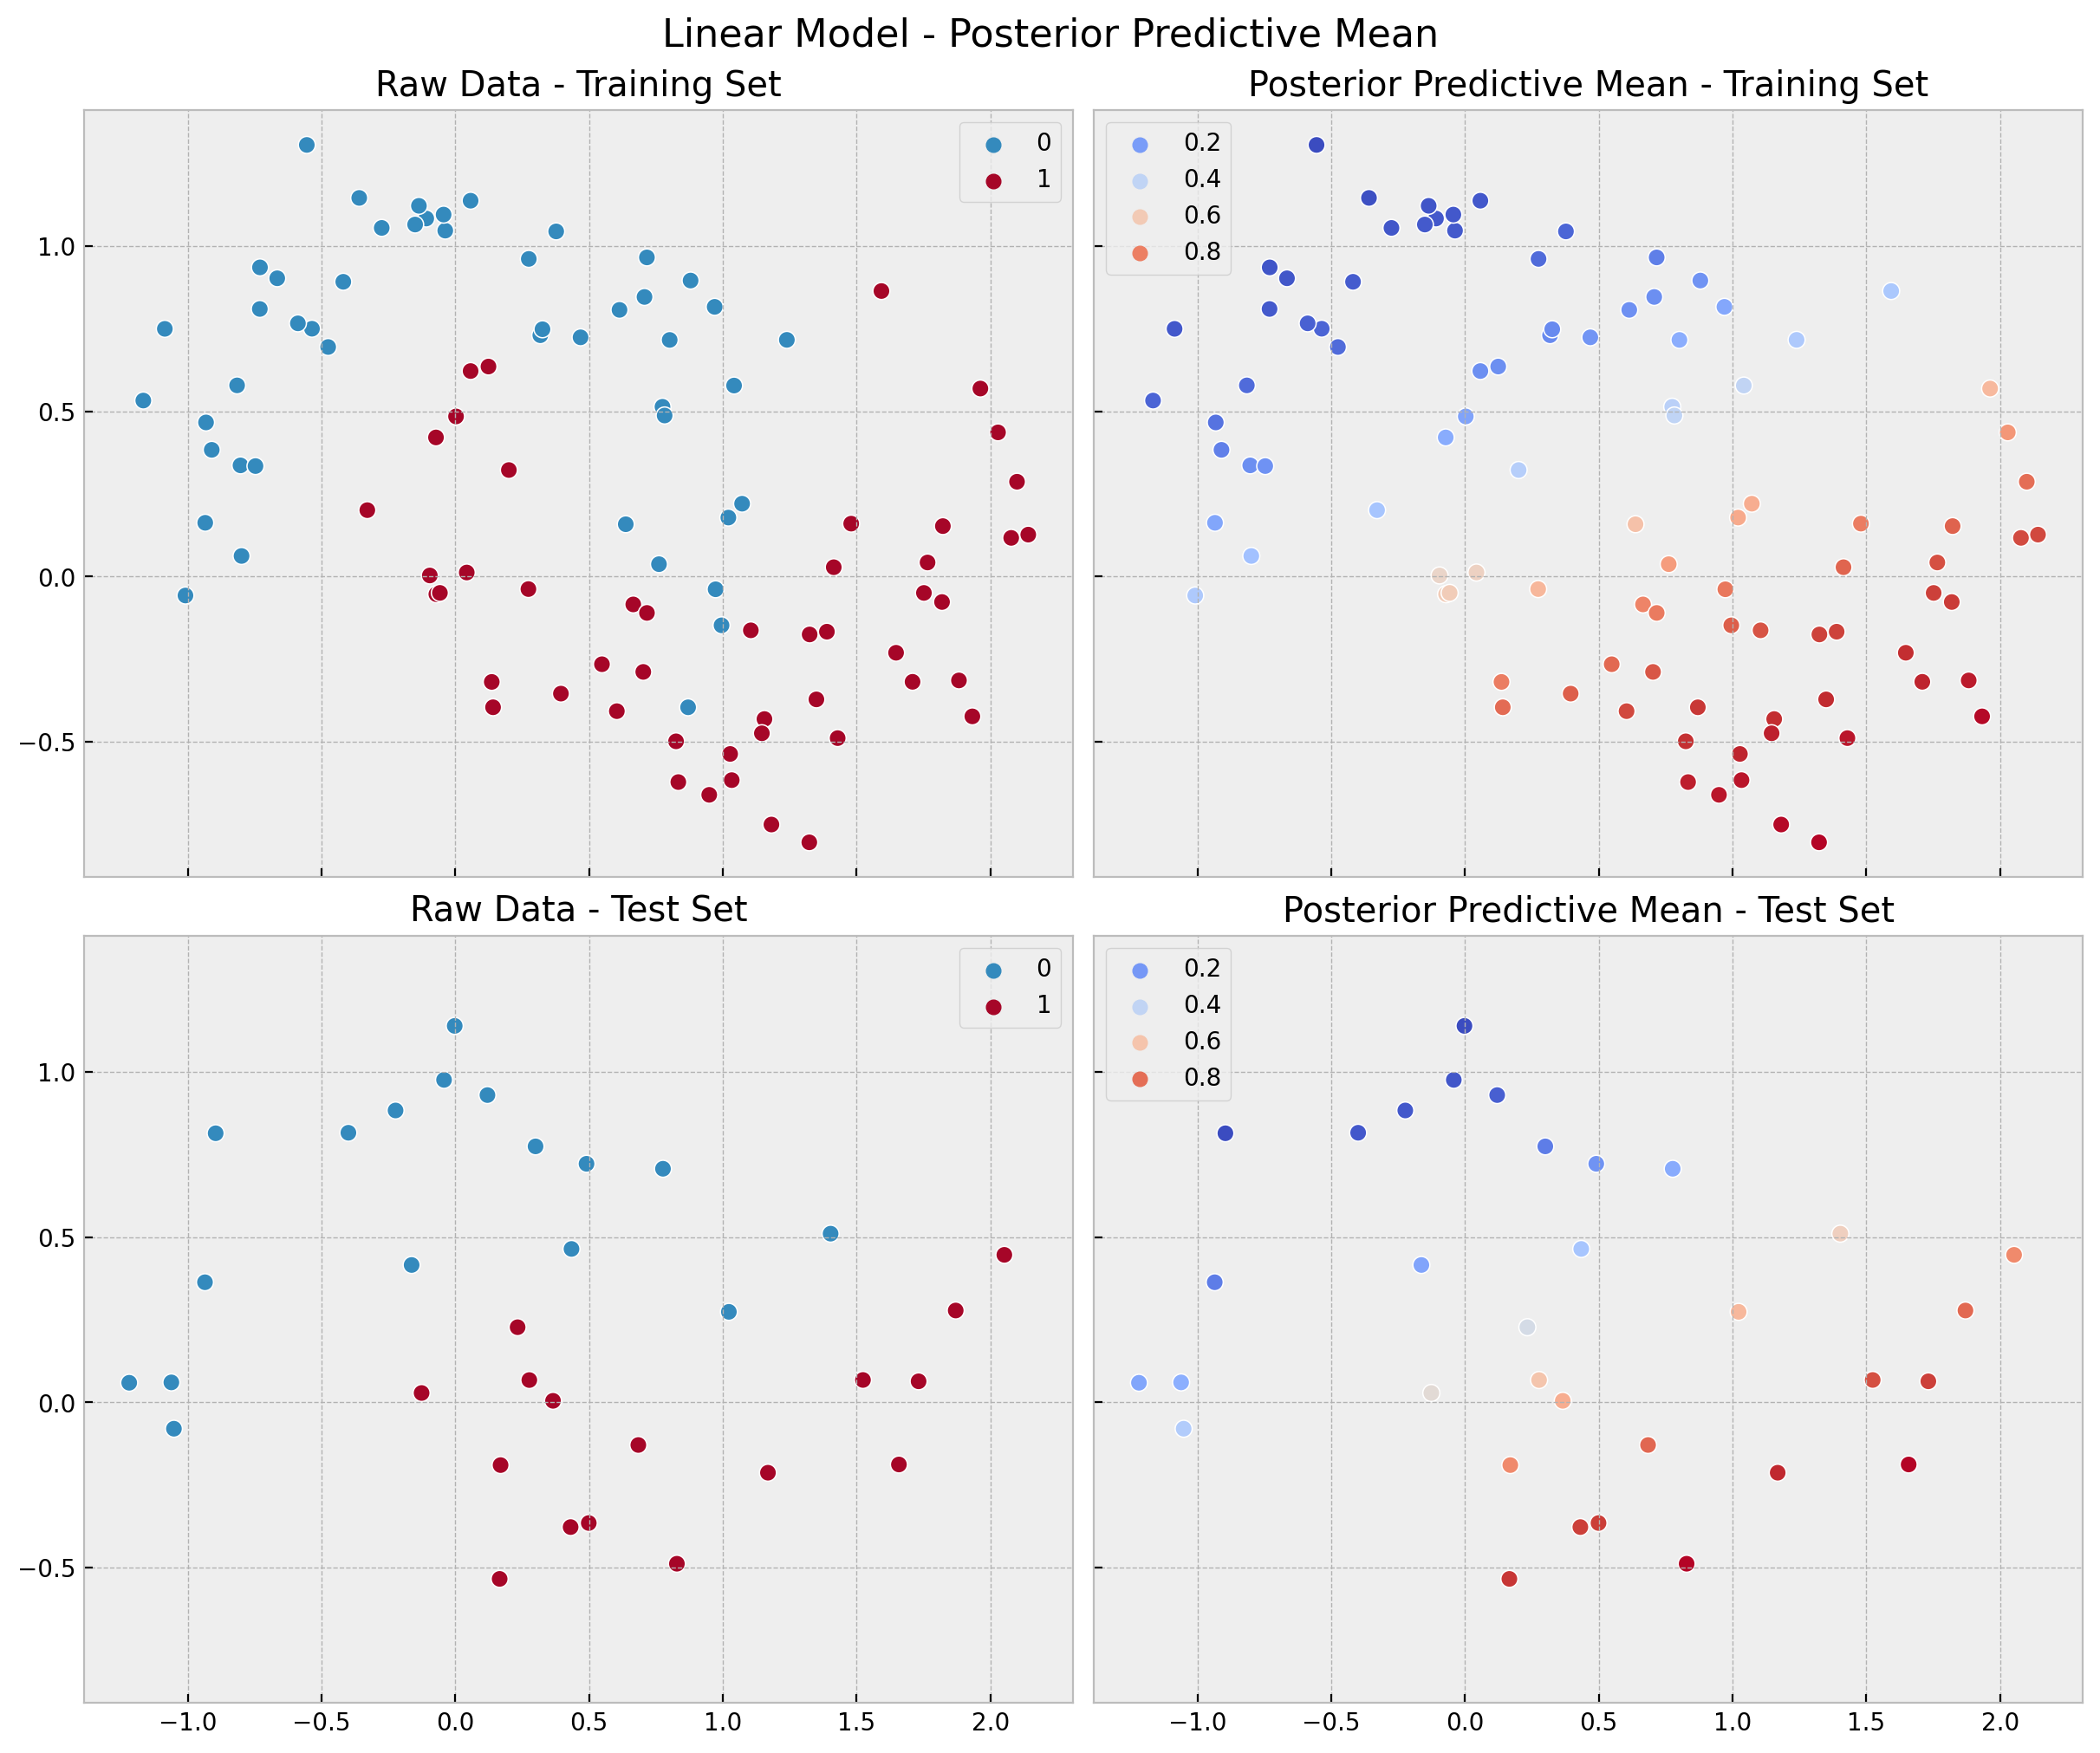

In [12]:
linear_posterior_predictive_mean_train = (
    linear_posterior_predictive.posterior_predictive["likelihood"]
    .stack(sample=("chain", "draw"))
    .mean(axis=1)
)

linear_posterior_predictive_mean_test = (
    linear_idata.posterior_predictive["likelihood"]
    .stack(sample=("chain", "draw"))
    .mean(axis=1)
)

fig, ax = plt.subplots(
    nrows=2, ncols=2, figsize=(12, 10), sharex=True, sharey=True, layout="constrained"
)

sns.scatterplot(x=x_train[:, 0], y=x_train[:, 1], s=50, hue=y_train, ax=ax[0, 0])
ax[0, 0].set(title="Raw Data - Training Set")

sns.scatterplot(
    x=x_train[:, 0],
    y=x_train[:, 1],
    s=50,
    hue=linear_posterior_predictive_mean_train,
    palette="coolwarm",
    ax=ax[0, 1],
)
ax[0, 1].legend(loc="upper left")
ax[0, 1].set(title="Posterior Predictive Mean - Training Set")

sns.scatterplot(x=x_test[:, 0], y=x_test[:, 1], s=50, hue=y_test, ax=ax[1, 0])
ax[1, 0].set(title="Raw Data - Test Set")

sns.scatterplot(
    x=x_test[:, 0],
    y=x_test[:, 1],
    s=50,
    hue=linear_posterior_predictive_mean_test,
    palette="coolwarm",
    ax=ax[1, 1],
)
ax[1, 1].legend(loc="upper left")
ax[1, 1].set(title="Posterior Predictive Mean - Test Set")
fig.suptitle("Linear Model - Posterior Predictive Mean", fontsize=16);

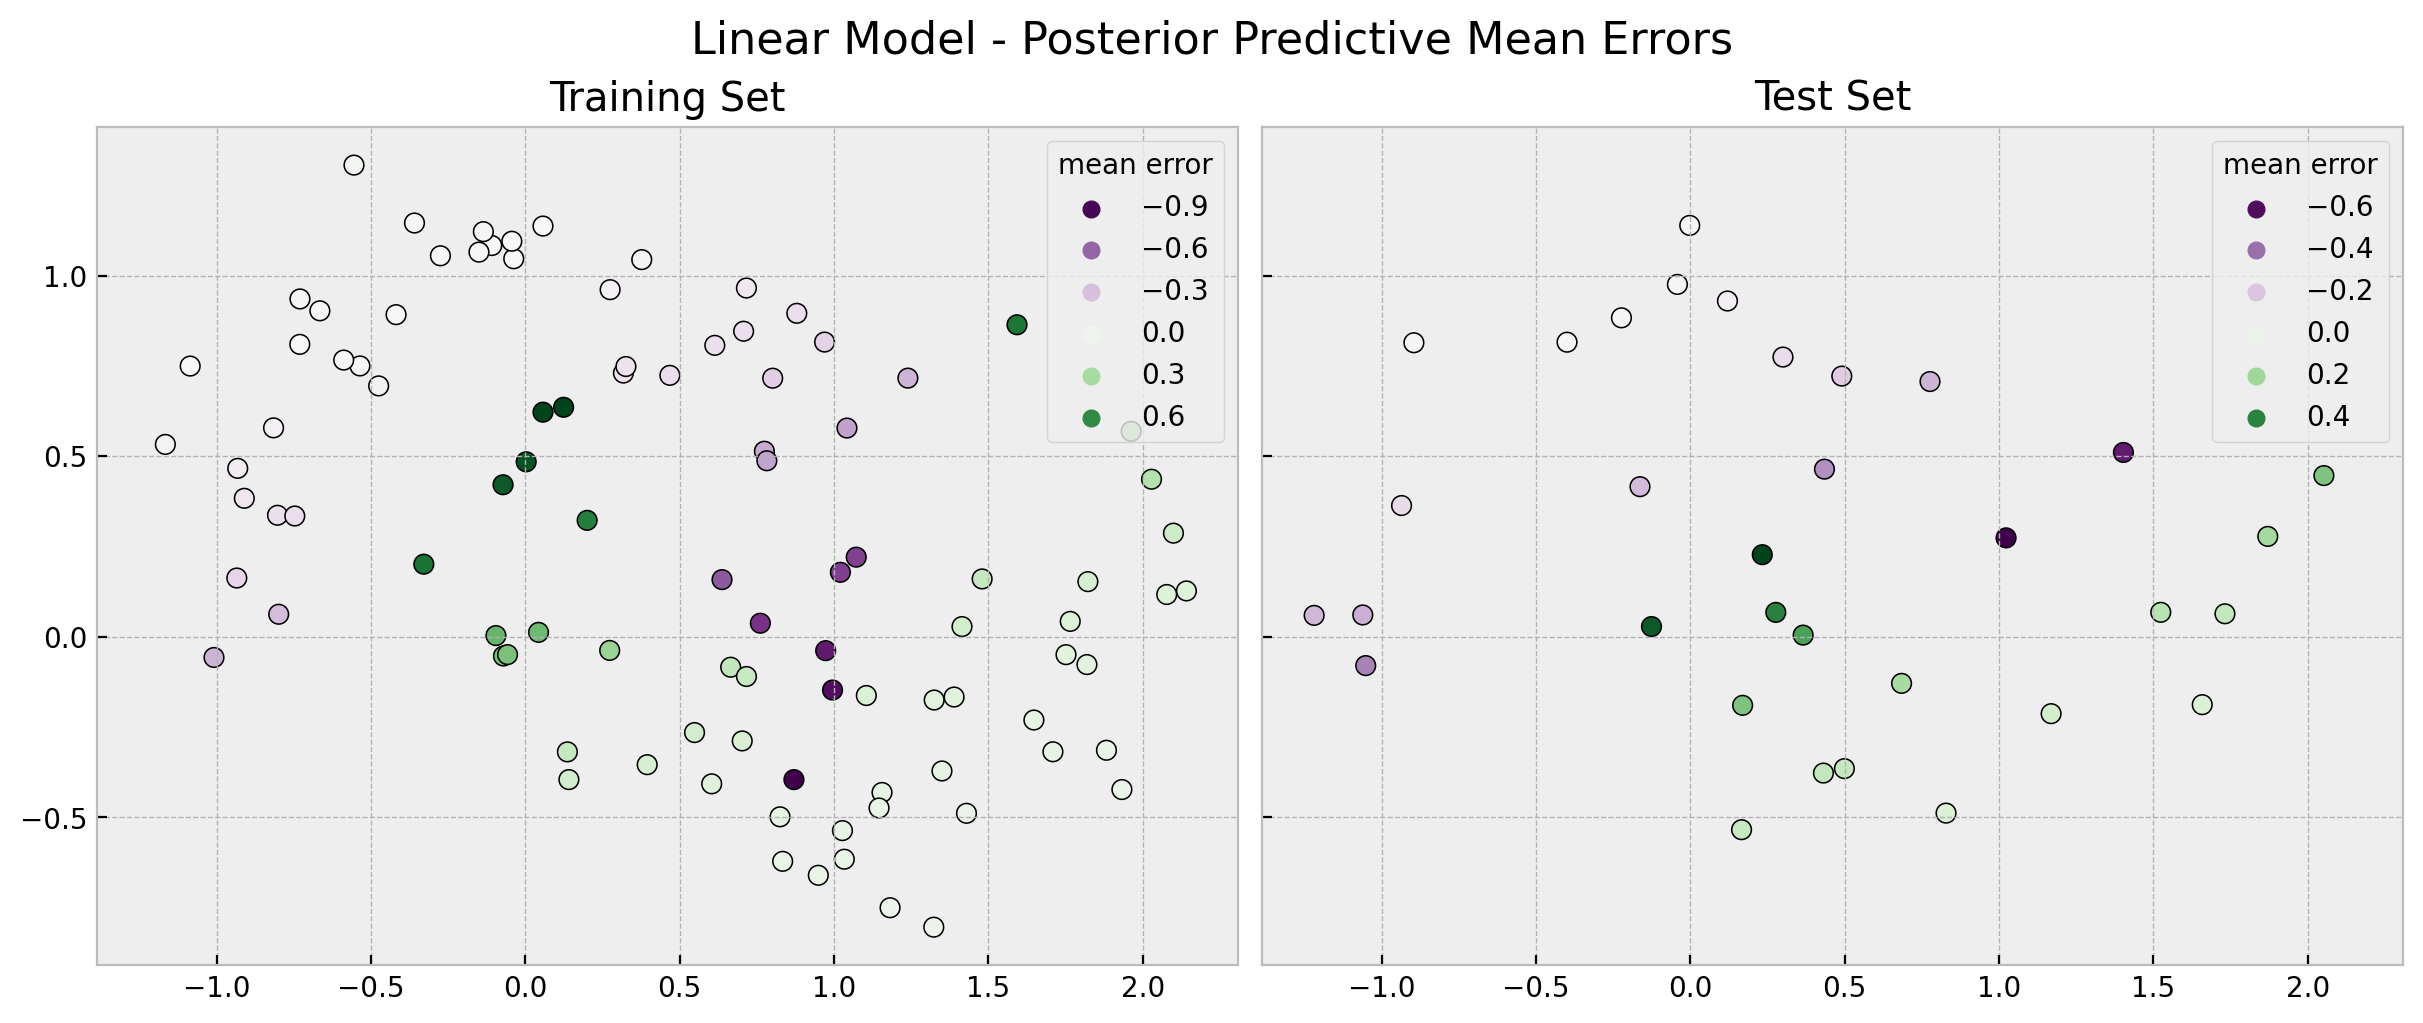

In [13]:
linear_errors_mean_train = (
    y_train[..., None] - linear_posterior_predictive.posterior_predictive["likelihood"].stack(sample=("chain", "draw"))
).mean(axis=1)

linear_errors_mean_test = (
    y_test[..., None] - linear_idata.posterior_predictive["likelihood"].stack(sample=("chain", "draw"))
).mean(axis=1)

fig, ax = plt.subplots(
    nrows=1, ncols=2, figsize=(12, 5), sharex=True, sharey=True, layout="constrained"
)
sns.scatterplot(x=x_train[:, 0], y=x_train[:, 1], s=50, edgecolor="black", hue=linear_errors_mean_train, palette="PRGn", ax=ax[0])
ax[0].legend(title="mean error")
ax[0].set(title="Training Set")

sns.scatterplot(x=x_test[:, 0], y=x_test[:, 1], s=50, edgecolor="black", hue=linear_errors_mean_test, palette="PRGn", ax=ax[1])
ax[1].legend(title="mean error")
ax[1].set(title="Test Set")
fig.suptitle("Linear Model - Posterior Predictive Mean Errors", fontsize=16);

## Gaussian Process

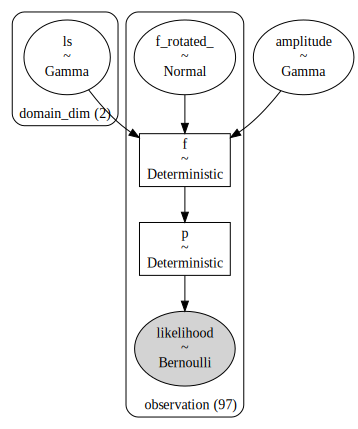

In [24]:
with pm.Model(coords={"observation": range(n_train), "domain_dim": [0, 1]}) as gp_model:

    ls = pm.Gamma(name="ls", alpha=2, beta=1, dims="domain_dim")
    amplitude = pm.Gamma(name="amplitude", alpha=2, beta=1)
    cov = amplitude ** 2 * pm.gp.cov.ExpQuad(input_dim=2, ls=ls)

    gp= pm.gp.Latent(cov_func=cov)
    f = gp.prior(name="f", X=x_train, dims="observation")
    p = pm.Deterministic(name="p", var=pm.math.sigmoid(f), dims="observation")
    # likelihood
    likelihood = pm.Bernoulli(name="likelihood", p=p, dims="observation", observed=y_train)

pm.model_to_graphviz(model=gp_model)

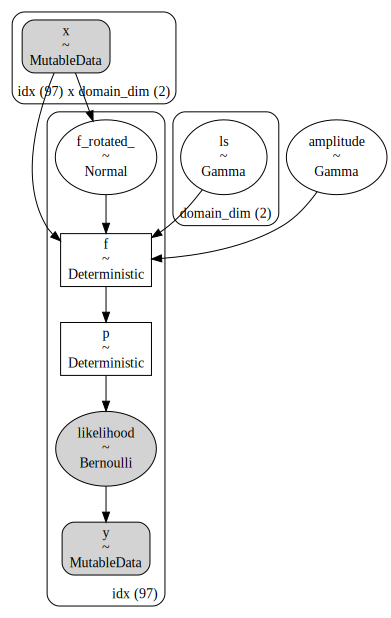

In [14]:
# with pm.Model() as gp_model:
#     # coordinates
#     gp_model.add_coord(name="domain_dim", values=np.arange(domain_dim), mutable=False)
#     gp_model.add_coord(name="idx", values=idx_train, mutable=True)
#     # data containers
#     x_ = pm.MutableData(name="x", value=x_train, dims=("idx", "domain_dim"))
#     y_ = pm.MutableData(name="y", value=y_train, dims="idx")

#     ls = pm.Gamma(name="ls", alpha=2, beta=1, dims="domain_dim")
#     amplitude = pm.Gamma(name="amplitude", alpha=2, beta=1)
#     cov = amplitude ** 2 * pm.gp.cov.ExpQuad(input_dim=2, ls=ls)

#     gp= pm.gp.Latent(cov_func=cov)
#     f = gp.prior(name="f", X=x_, dims="idx")
#     p = pm.Deterministic(name="p", var=pm.math.invlogit(f), dims="idx")
#     # likelihood
#     likelihood = pm.Bernoulli(name="likelihood", p=p, observed=y_, dims="idx")

# pm.model_to_graphviz(model=gp_model)

In [25]:
with gp_model:
    gp_idata = pm.sampling_jax.sample_numpyro_nuts(draws=4000, chains=4)
    gp_posterior_predictive = pm.sample_posterior_predictive(trace=gp_idata)

Compiling...
Compilation time =  0:00:03.091185
Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Sampling time =  0:03:44.076495
Transforming variables...
Transformation time =  0:00:37.651936
Computing Log Likelihood...
Log Likelihood time =  0:00:26.573284


In [26]:
az.summary(data=gp_idata, var_names=["ls", "amplitude"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ls[0],0.552,0.122,0.323,0.786,0.002,0.001,5627.0,6532.0,1.0
ls[1],1.138,0.439,0.468,1.938,0.007,0.005,4431.0,7681.0,1.0
amplitude,6.783,2.044,3.254,10.585,0.020,0.014,9994.0,11018.0,1.0


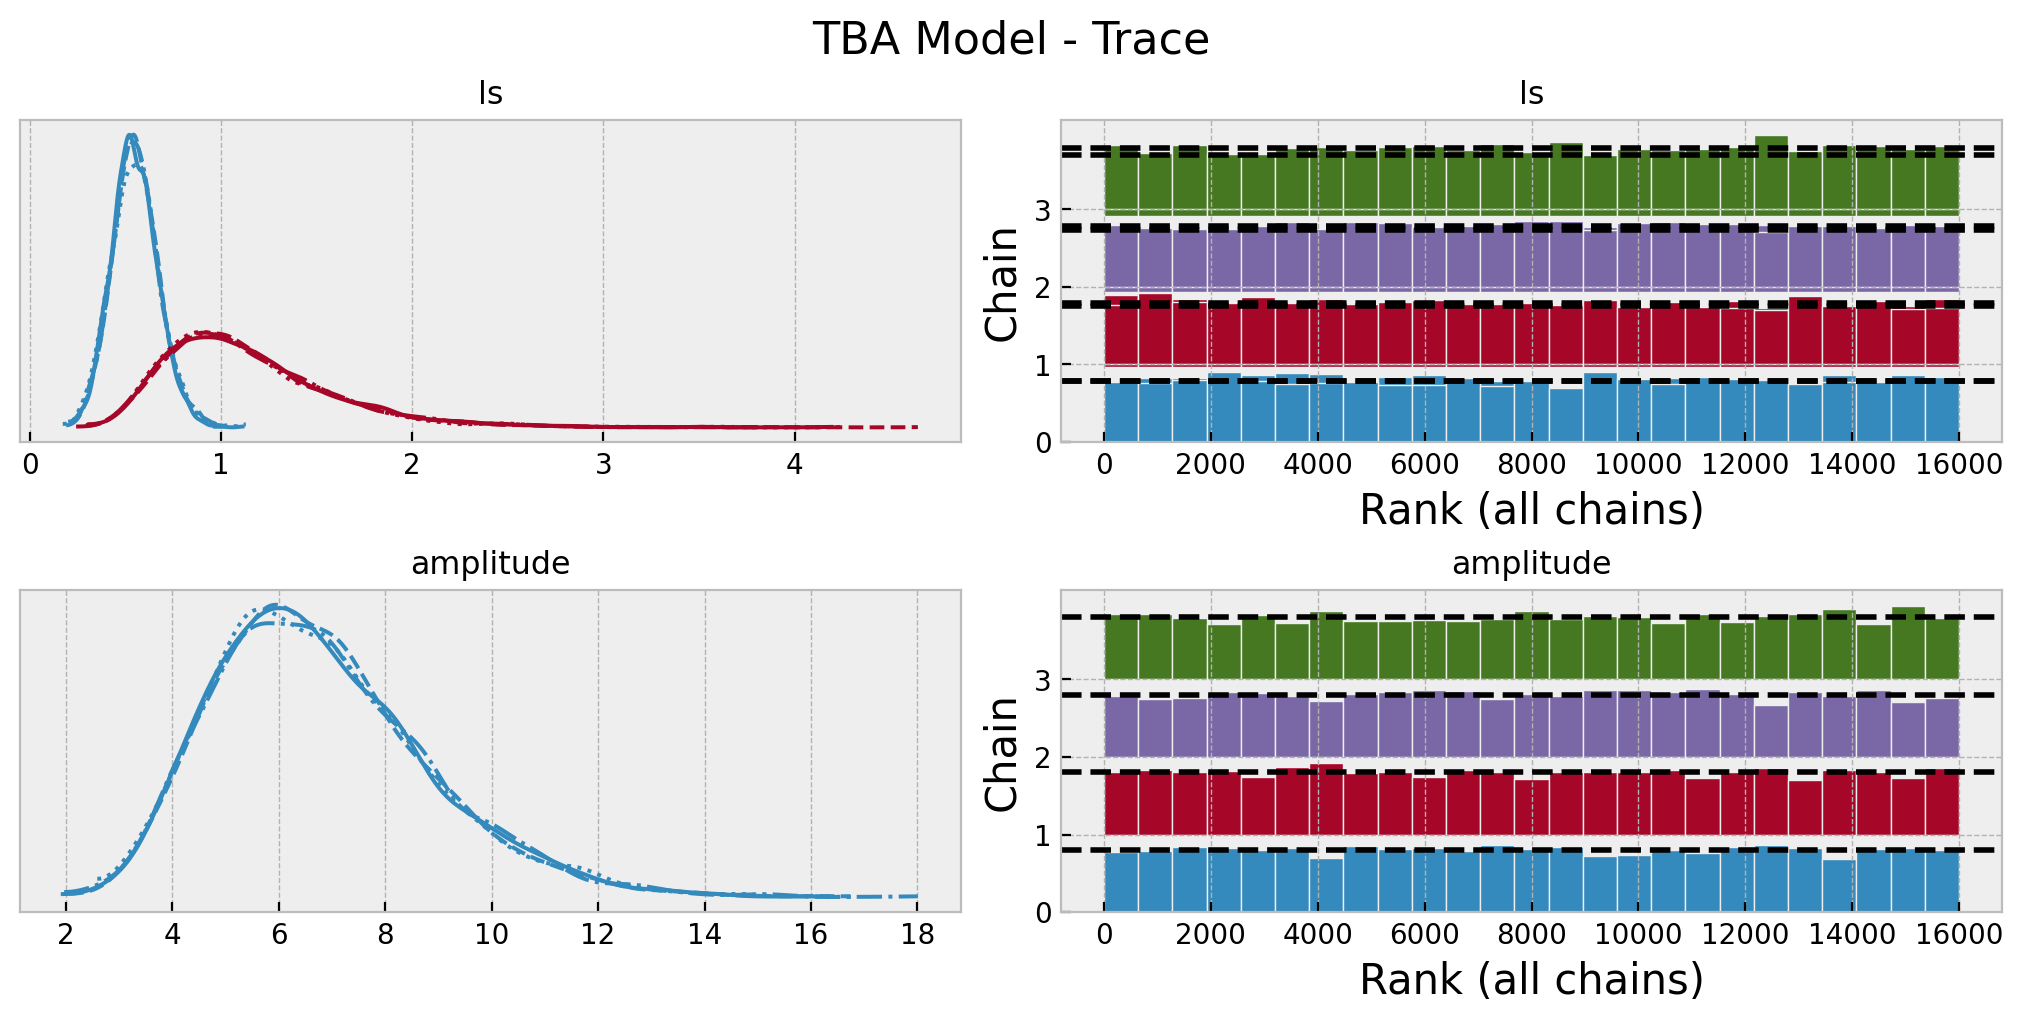

In [27]:
axes = az.plot_trace(
    data=gp_idata,
    var_names=["ls", "amplitude"],
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (10, 5), "layout": "constrained"},
)
plt.gcf().suptitle("TBA Model - Trace", fontsize=16);

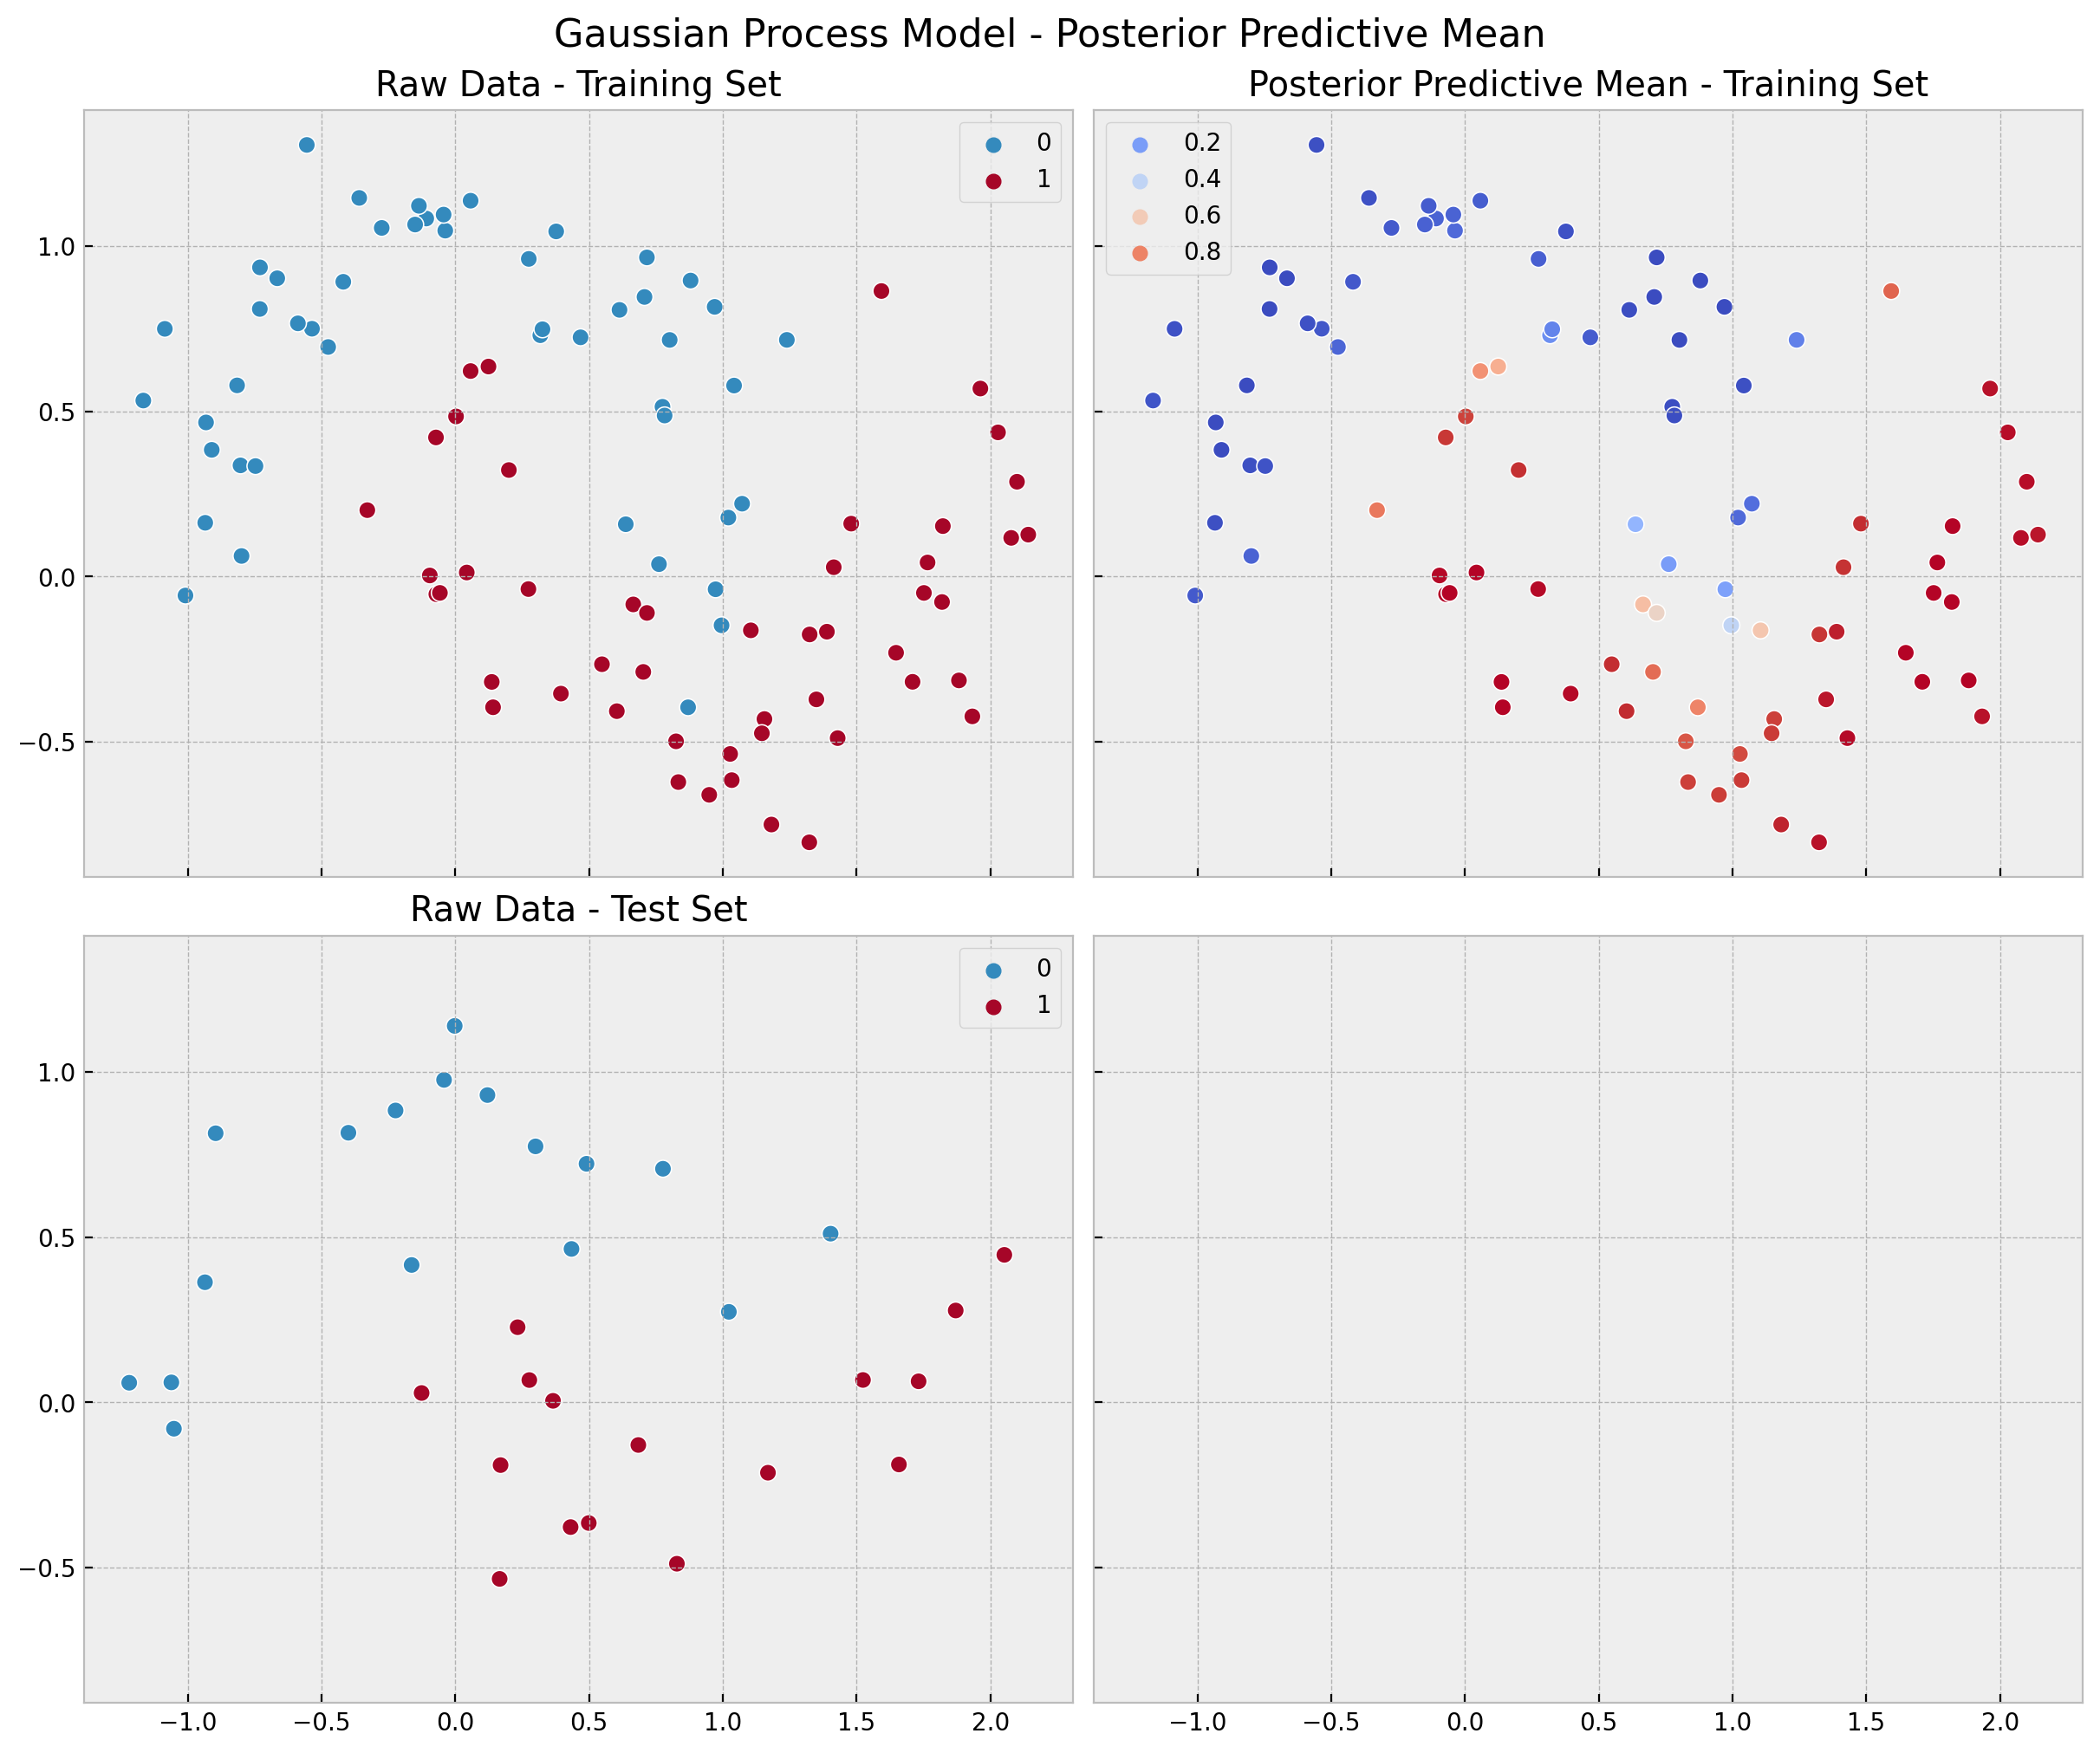

In [28]:
gp_posterior_predictive_mean_train = (
    gp_posterior_predictive.posterior_predictive["likelihood"]
    .stack(sample=("chain", "draw"))
    .mean(axis=1)
)

# linear_posterior_predictive_mean_test = (
#     linear_idata.posterior_predictive["likelihood"]
#     .stack(sample=("chain", "draw"))
#     .mean(axis=1)
# )

fig, ax = plt.subplots(
    nrows=2, ncols=2, figsize=(12, 10), sharex=True, sharey=True, layout="constrained"
)

sns.scatterplot(x=x_train[:, 0], y=x_train[:, 1], s=50, hue=y_train, ax=ax[0, 0])
ax[0, 0].set(title="Raw Data - Training Set")

sns.scatterplot(
    x=x_train[:, 0],
    y=x_train[:, 1],
    s=50,
    hue=gp_posterior_predictive_mean_train,
    palette="coolwarm",
    ax=ax[0, 1],
)
ax[0, 1].legend(loc="upper left")
ax[0, 1].set(title="Posterior Predictive Mean - Training Set")

sns.scatterplot(x=x_test[:, 0], y=x_test[:, 1], s=50, hue=y_test, ax=ax[1, 0])
ax[1, 0].set(title="Raw Data - Test Set")

# sns.scatterplot(
#     x=x_test[:, 0],
#     y=x_test[:, 1],
#     s=50,
#     hue=linear_posterior_predictive_mean_test,
#     palette="coolwarm",
#     ax=ax[1, 1],
# )
# ax[1, 1].legend(loc="upper left")
# ax[1, 1].set(title="Posterior Predictive Mean - Test Set")
fig.suptitle("Gaussian Process Model - Posterior Predictive Mean", fontsize=16);

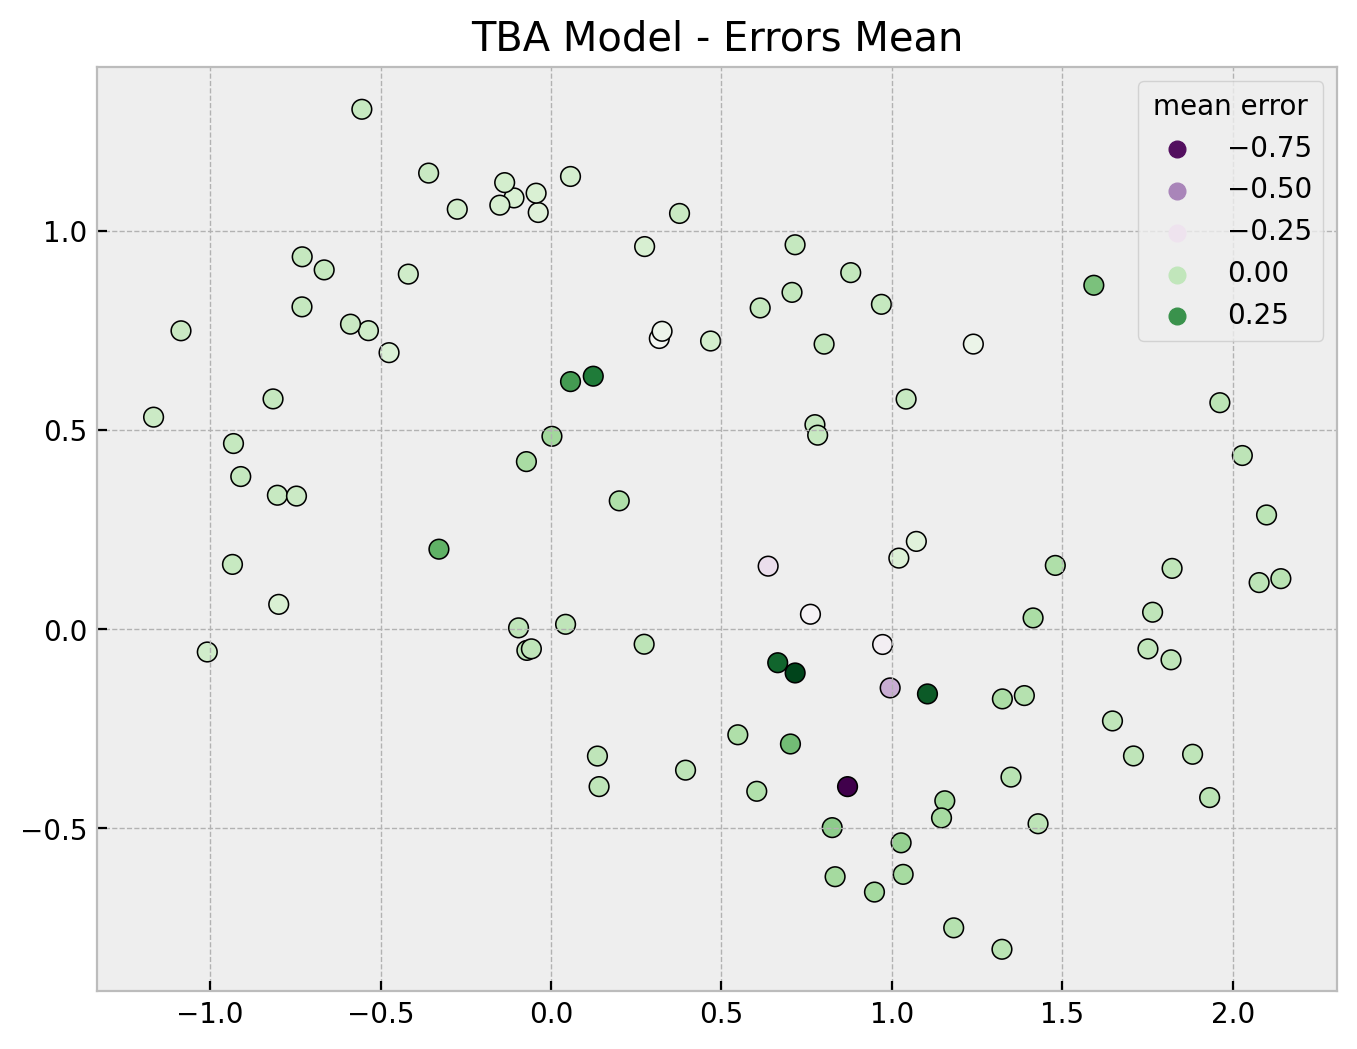

In [29]:
gp_errors_mean_train = (
    y_train[..., None] - gp_posterior_predictive.posterior_predictive["likelihood"].stack(sample=("chain", "draw"))
).mean(axis=1)

fig, ax = plt.subplots()
sns.scatterplot(x=x_train[:, 0], y=x_train[:, 1], s=50, edgecolor="black", hue=gp_errors_mean_train, palette="PRGn", ax=ax)
ax.legend(title="mean error")
ax.set(title="TBA Model - Errors Mean");

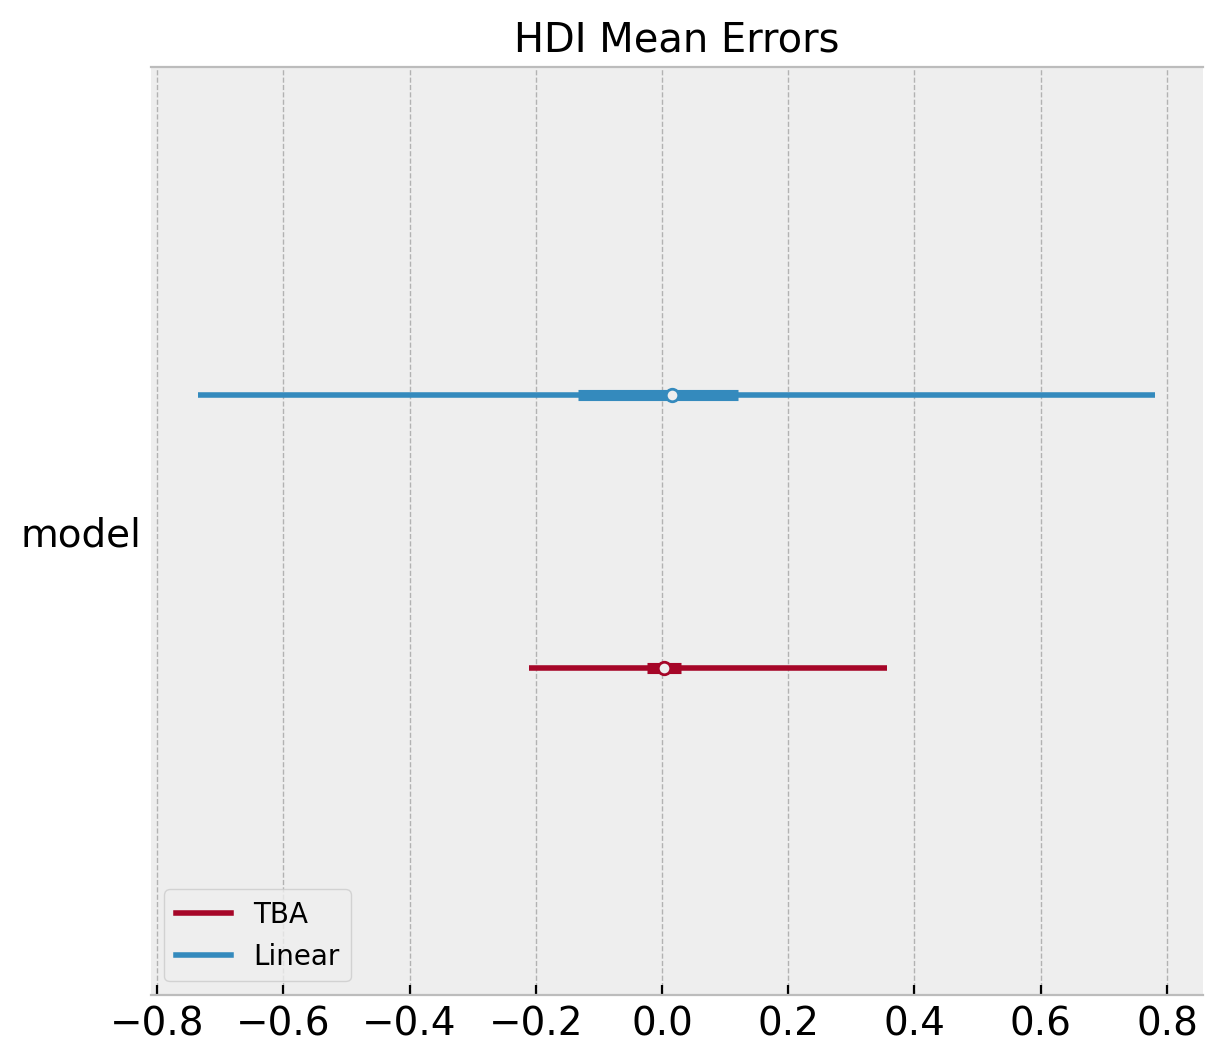

In [30]:
ax, *_ = az.plot_forest(
    [
        az.convert_to_dataset(obj={"model": linear_errors_mean_train.to_numpy()}),
        az.convert_to_dataset(obj={"model": gp_errors_mean_train.to_numpy()}),
    ],
    model_names=["Linear", "TBA"],
    backend_kwargs={"layout": "constrained"},
)
ax.set(title="HDI Mean Errors");

In [ ]:
az.compare(compare_dict={"Linear": linear_idata, "TBA": gp_idata})

In [ ]:
fig, ax = plt.subplots(
        nrows=2, ncols=1, figsize=(9, 4), layout="constrained"
)
az.plot_separation(idata=linear_posterior_predictive, y="likelihood", ax=ax[0])
ax[0].set(title="Linear Model")
az.plot_separation(idata=gp_posterior_predictive, y="likelihood", ax=ax[1])
ax[1].set(title="TBA Model")
fig.suptitle("Separation Plot", fontsize=16);